In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFrameProcessor import DataFrameProcessor

In [2]:
df = pd.read_csv("./data/anonymized_sales.csv")
df

,Transaktionsschlüssel,Niederlassung,Datum,Transaktionstyp,Retailtypcode,Kundennummer,Artikelnummer,Produkt Bez.,Warengruppe,Warengruppe Bez.,Verkaufsmenge,Umsatz,Dummy-Bestellkanal
0,172410,NL Bochum,20241109,1001,2002,21351,358,Schweine-Schnitzel Surprise,4,Fleisch,1,17.49,Online
1,302844,NL Münster,20241120,1001,2002,38446,546,Elite Choice,14,Nicht-TK,1,15.99,Verkauf
2,302844,NL Münster,20241120,1001,2002,38446,486,Nuss-Honig-Krokant,14,Nicht-TK,1,13.99,Verkauf
3,232610,NL Gelsenkirchen,20241207,1001,2002,11475,653,Zuckerkristall-Eis,1,Eis,1,9.99,Online
4,232610,NL Gelsenkirchen,20241207,1001,2002,11475,557,Gourmet-Deluxe-Trüffelauswahl,14,Nicht-TK,1,16.99,Online
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583519,190477,NL Gelsenkirchen,20250204,1401,2802,24926,634,Back deine Brezeln,11,Brot & Backwaren,-1,-5.99,Telefon
1583520,190477,NL Gelsenkirchen,20250204,1401,2802,24926,837,F-Superknusper-Kroketten,6,Kartoffelprodukte,-2,-6.98,Telefon
1583521,190477,NL Gelsenkirchen,20250204,1401,2802,24926,102,Teeschleife,11,Brot & Backwaren,-1,-9.49,Telefon
1583522,190477,NL Gelsenkirchen,20250204,1401,2802,24926,487,Mini-Butterkrummerecken,11,Brot & Backwaren,-1,-7.49,Telefon


In [3]:
warengruppe_lookup = df[["Warengruppe Bez.", "Warengruppe"]].drop_duplicates(subset=["Warengruppe"], keep="first")
warengruppe_lookup

,Warengruppe Bez.,Warengruppe
0,Fleisch,4
1,Nicht-TK,14
3,Eis,1
5,Fertige Gerichte,2
7,Fisch & Meeresfrücht,5
8,Brot & Backwaren,11
11,Pizza & Snacks,9
13,Geflügel,3
18,Kartoffelprodukte,6
20,Gemüse,7


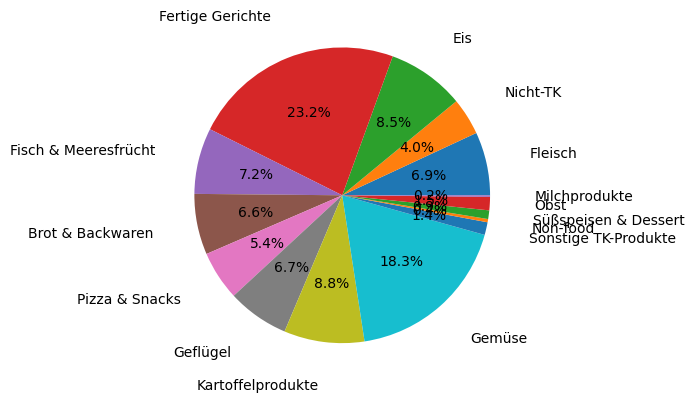

In [4]:
val_counts = df["Warengruppe"].value_counts()
val_counts = warengruppe_lookup.join(val_counts, on="Warengruppe")
val_counts.reset_index(inplace=True)
#plt.pie(val_counts)
#plt.show()
val_counts
plt.pie(val_counts["count"], labels=val_counts["Warengruppe Bez."], autopct='%1.1f%%', labeldistance=1.3)
plt.show()


In [4]:
df_proc = DataFrameProcessor(df, [], "Datum", "Verkaufsmenge", "Verkaufsmenge", "GraphName", withGraph=True)
#df_proc.reset_df(df)
#df_proc.change_target(timeseries)
#df_proc.filter_by_date(start_date, end_date, inplace=True)
#df_proc.filter_by_specified_columns(dict(zip(self.df_proc.filter_columns, vals)), inplace=True)
df_proc.aggregate(inplace=True)
#df_proc.aggregate_by_timespan(start_date, end_date, inplace=True)
df_proc.add_prediction("Sales Vorhersage", 100, lambda df: df[df_proc.target] + 1000, inplace=True)
df_proc.add_prediction("Sales Vorhersage 2", 100, lambda df: df[df_proc.target] - 1000, inplace=True)

In [5]:
df_proc.df["GraphName"].unique()

array(['Verkaufsmenge', 'Sales Vorhersage', 'Sales Vorhersage 2'],
      dtype=object)

         Datum  Verkaufsmenge           GraphName  outlier
0   2024-10-14          16352       Verkaufsmenge    False
1   2024-10-15          16413       Verkaufsmenge    False
2   2024-10-16          15310       Verkaufsmenge    False
3   2024-10-17          15328       Verkaufsmenge    False
4   2024-10-18          14847       Verkaufsmenge    False
..         ...            ...                 ...      ...
305 2025-02-25          14478  Sales Vorhersage 2    False
306 2025-02-26          13604  Sales Vorhersage 2    False
307 2025-02-27          12764  Sales Vorhersage 2    False
308 2025-02-28          12500  Sales Vorhersage 2    False
309 2025-03-01           3162  Sales Vorhersage 2     True

[310 rows x 4 columns]


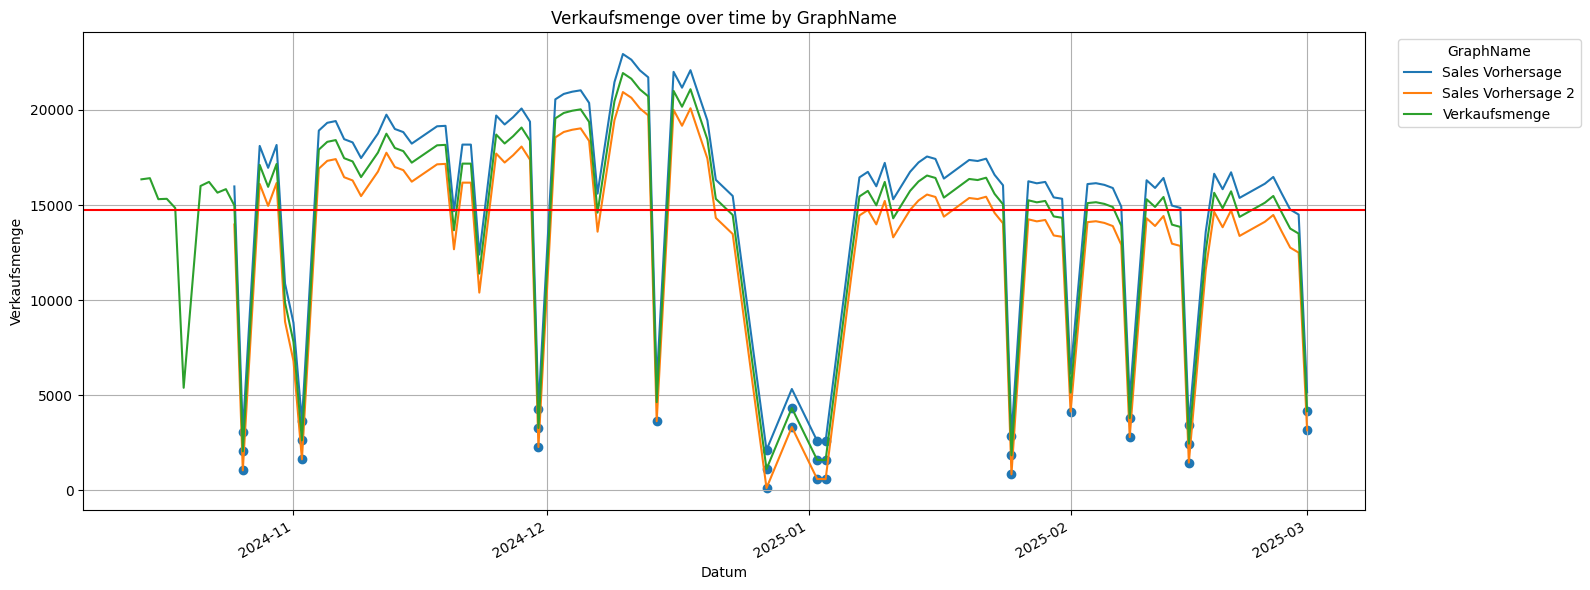

In [12]:
ps = df_proc.df.copy()
print(ps)

# verify required columns
required = {'Datum', 'Verkaufsmenge', 'GraphName'}
missing = required - set(ps.columns)
if missing:
    raise KeyError(f"Missing columns in processed dataframe: {missing}")

# convert Datum to datetime (handles integers like 20241109)
if not np.issubdtype(ps['Datum'].dtype, np.datetime64):
    try:
        ps['Datum_dt'] = pd.to_datetime(ps['Datum'], format='%Y%m%d')
    except Exception:
        ps['Datum_dt'] = pd.to_datetime(ps['Datum'], errors='coerce')
else:
    ps['Datum_dt'] = ps['Datum']

ps = ps.sort_values('Datum_dt')

# plot time series, one line per GraphName category
fig, ax = plt.subplots(figsize=(16, 6))
for name, grp in ps.groupby('GraphName'):
    ax.plot(grp['Datum_dt'], grp['Verkaufsmenge'], label=str(name))

outliers = ps[ps["outlier"]]
ax.scatter(outliers['Datum_dt'], outliers['Verkaufsmenge'],marker='o')
ax.axhline(ps["Verkaufsmenge"].mean(), color='r') # horizontal

ax.set_xlabel('Datum')
ax.set_ylabel('Verkaufsmenge')
ax.set_title('Verkaufsmenge over time by GraphName')
ax.legend(title='GraphName', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Use STD-Method to localize anomalies and smoothen the data

In [11]:
df = df_proc.df
#q1 = np.quantile(df["Verkaufsmenge"], 0.25)
#q3 = np.quantile(df["Verkaufsmenge"], 0.75)
#iqr = q1-q3
sd = df["Verkaufsmenge"].std()
mean = df["Verkaufsmenge"].mean()

lower_boundary = mean - 2 * sd
upper_boundary = mean + 2 * sd
df["outlier"] = (df["Verkaufsmenge"] < lower_boundary) | (df["Verkaufsmenge"] > upper_boundary)
df_proc.reset_df(df, full_reset=True)
print(df_proc.df)


         Datum  Verkaufsmenge           GraphName  outlier
0   2024-10-14          16352       Verkaufsmenge    False
1   2024-10-15          16413       Verkaufsmenge    False
2   2024-10-16          15310       Verkaufsmenge    False
3   2024-10-17          15328       Verkaufsmenge    False
4   2024-10-18          14847       Verkaufsmenge    False
..         ...            ...                 ...      ...
305 2025-02-25          14478  Sales Vorhersage 2    False
306 2025-02-26          13604  Sales Vorhersage 2    False
307 2025-02-27          12764  Sales Vorhersage 2    False
308 2025-02-28          12500  Sales Vorhersage 2    False
309 2025-03-01           3162  Sales Vorhersage 2     True

[310 rows x 4 columns]
